In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# === Load & Clean Data ===
df = pd.read_excel('coffee_shop_data.xlsx')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['DayOfWeek'] = df['DateTime'].dt.day_name()
df['Hour'] = df['DateTime'].dt.hour
df['Date'] = df['DateTime'].dt.date
df['PromoCode'] = df['PromoCode'].fillna('NONE').astype(str).str.upper()

In [3]:
# === Use in-memory SQLite database ===
conn = sqlite3.connect(':memory:')
df.to_sql('data', conn, index=False)

6921

In [4]:
# === Utility ===
def run_query(query):
    return pd.read_sql_query(query, conn)

def show_section(title):
    print(f"\n--- {title} ---")

In [5]:
# === Summary ===
show_section("Data Overview")
df.info()
print("\nMissing Values:\n", df.isna().sum())
print("\nAverage Revenue Per Transaction:", df['Revenue'].mean())


--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6921 entries, 0 to 6920
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       6921 non-null   datetime64[ns]
 1   CustomerID     6921 non-null   object        
 2   Product        6921 non-null   object        
 3   Category       6921 non-null   object        
 4   OriginalPrice  6921 non-null   float64       
 5   Revenue        6921 non-null   float64       
 6   Branch         6921 non-null   object        
 7   PaymentMethod  6921 non-null   object        
 8   PromoCode      6921 non-null   object        
 9   TransactionID  6921 non-null   int64         
 10  EmployeeID     6921 non-null   object        
 11  Tip            6921 non-null   float64       
 12  DayOfWeek      6921 non-null   object        
 13  Hour           6921 non-null   int32         
 14  Date           6921 non-null   object        
dty

In [6]:
# === Product Analysis ===
show_section("Top Products by Revenue")
print(run_query('''
    SELECT Product, SUM(Revenue) AS Total_Revenue, COUNT(*) AS Quantity_Sold
    FROM data GROUP BY Product ORDER BY Total_Revenue DESC LIMIT 11
'''))

show_section("Least Popular Products")
print(run_query('''
    SELECT Product, SUM(Revenue) AS Total_Revenue, COUNT(*) AS Quantity_Sold
    FROM data GROUP BY Product ORDER BY Total_Revenue ASC LIMIT 11
'''))

show_section("Net Revenue")
print(run_query('SELECT SUM(Revenue) AS Net_Revenue FROM data'))


--- Top Products by Revenue ---
          Product  Total_Revenue  Quantity_Sold
0   Avocado Toast      1546.8050            340
1        Smoothie      1401.0400            378
2       Cold Brew      1167.4875            338
3           Mocha      1061.6250            327
4      Cappuccino      1034.8025            345
5        Sandwich      1029.2500            211
6           Latte      1013.0700            327
7       Croissant       944.3800            327
8          Muffin       890.2200            323
9        Espresso       877.5950            363
10      Americano       836.7925            322

--- Least Popular Products ---
          Product  Total_Revenue  Quantity_Sold
0    Matcha Latte       257.2700            101
1       Macchiato       296.8225             93
2     Energy Ball       302.5200            101
3     Apple Juice       311.4000            121
4      Flat White       312.9600            103
5   Cheese Danish       320.0725             93
6     Frappuccino      

In [7]:
# === Product Bundling ===
show_section("Top Product Bundles")
print(run_query('''
    SELECT a.Product AS Product1, b.Product AS Product2, COUNT(*) AS TimesBoughtTogether
    FROM data a JOIN data b ON a.TransactionID = b.TransactionID AND a.Product < b.Product
    GROUP BY a.Product, b.Product ORDER BY TimesBoughtTogether DESC
'''))

show_section("Category Bundle Trends")
print(run_query('''
    SELECT a.Category AS Category1, b.Category AS Category2, COUNT(*) AS CategoryBundles
    FROM data a JOIN data b ON a.TransactionID = b.TransactionID AND a.Product < b.Product
    GROUP BY a.Category, b.Category ORDER BY CategoryBundles DESC
'''))

category_bundle_df = run_query('''
    SELECT 
        a.Category AS Category1, 
        b.Category AS Category2, 
        COUNT(*) AS CategoryBundles,
        SUM(a.Revenue + b.Revenue) AS BundleRevenue -- optional for revenue measure
    FROM data a 
    JOIN data b 
      ON a.TransactionID = b.TransactionID 
     AND a.Product < b.Product
    GROUP BY a.Category, b.Category
    ORDER BY CategoryBundles DESC
''')

category_bundle_df.to_csv('category_bundles.csv', index=False)



--- Top Product Bundles ---
         Product1         Product2  TimesBoughtTogether
0     Granola Bar         Smoothie                  143
1          Cookie              Tea                  141
2      Cappuccino            Scone                  136
3        Espresso           Muffin                  132
4   Avocado Toast         Iced Tea                  125
5     Iced Coffee            Salad                  125
6     Apple Juice            Mocha                  121
7     Apple Juice  Veggie Sandwich                  121
8           Mocha  Veggie Sandwich                  121
9       Americano            Donut                  120
10      Cold Brew      Protein Bar                  119
11      Croissant            Latte                  116
12          Bagel     Orange Juice                  113
13        Brownie      Frappuccino                  112
14   Banana Bread       Flat White                  103
15    Energy Ball     Matcha Latte                  101
16  Cheese Danish  

In [8]:
# === Payment Preferences ===
show_section("Payment Method Preferences")
print(run_query('''
    SELECT PaymentMethod AS PreferredPayment, SUM(Revenue) AS TotalRevenue, SUM(Tip) AS TipsMade
    FROM data GROUP BY PaymentMethod ORDER BY TotalRevenue DESC
'''))


--- Payment Method Preferences ---
  PreferredPayment  TotalRevenue  TipsMade
0             Card    12451.6525   1416.10
1             Cash     6596.8425    722.49
2        MobilePay     1897.8675    220.43


In [9]:
# === Promo Code Insights ===
show_section("Promo Code Usage Summary")
print(run_query('''
    SELECT Promocode, COUNT(DISTINCT TransactionID) AS TransactionsMade,
           ROUND(COUNT(*) * 1.0 / COUNT(DISTINCT TransactionID), 2) AS AvgItemsPerTransaction,
           ROUND(SUM(Revenue), 2) AS RevenueMade,
           ROUND(SUM(Tip) * 100.0 / NULLIF(SUM(Revenue), 0), 2) AS TipPercentage
    FROM data GROUP BY Promocode ORDER BY RevenueMade DESC
'''))

show_section("Promo Code Category Breakdown")
print(run_query('''
    SELECT Promocode, Category, COUNT(*) AS TransactionsMade
    FROM data GROUP BY Promocode, Category ORDER BY TransactionsMade DESC
'''))

promo_usage_ratio = df[df['PromoCode'] != 'NONE'].shape[0] / df.shape[0]
print("\nPromo Code Usage Ratio:", round(promo_usage_ratio, 2))


--- Promo Code Usage Summary ---
   PromoCode  TransactionsMade  AvgItemsPerTransaction  RevenueMade  \
0       NONE              3811                    1.35     16848.00   
1    LOYAL10               513                    1.39      2135.50   
2   WEEKEND5               506                    1.38      1962.86   
3  FREEDRINK               357                    1.04         0.00   

   TipPercentage  
0          10.38  
1          11.35  
2          12.00  
3            NaN  

--- Promo Code Category Breakdown ---
    PromoCode               Category  TransactionsMade
0        NONE           Coffee-Based              1779
1        NONE            Baked Goods              1705
2        NONE           Savory Foods               626
3        NONE     Smoothies & Juices               414
4        NONE              Tea-Based               328
5        NONE  Snacks & Energy Bites               288
6   FREEDRINK           Coffee-Based               263
7     LOYAL10           Coffee-Based

In [10]:
# === Category Performance ===
show_section("Category Performance Breakdown")
category_perf = run_query('''
    SELECT 
        Category,
        COUNT(*) AS Items_Sold,
        COUNT(DISTINCT TransactionID) AS Transactions,
        SUM(Revenue) AS Total_Revenue,
        ROUND(AVG(Revenue), 2) AS Avg_Revenue_Per_Item
    FROM data
    GROUP BY Category
    ORDER BY Total_Revenue DESC
''')
print(category_perf)


--- Category Performance Breakdown ---
                Category  Items_Sold  Transactions  Total_Revenue  \
0           Coffee-Based        2556          2556      7543.9650   
1            Baked Goods        2112          2112      5711.9700   
2           Savory Foods         797           797      3339.2325   
3     Smoothies & Juices         612           612      2056.5800   
4  Snacks & Energy Bites         363           363      1161.5550   
5              Tea-Based         481           481      1133.0600   

   Avg_Revenue_Per_Item  
0                  2.95  
1                  2.70  
2                  4.19  
3                  3.36  
4                  3.20  
5                  2.36  


In [11]:
# === Customer Segmentation ===
show_section("Customer Segmentation")
customer_agg = df.groupby('CustomerID').agg(
    Total_Spend=('Revenue', 'sum'),
    Transaction_Count=('TransactionID', pd.Series.nunique)
).reset_index()

spend_thresholds = customer_agg['Total_Spend'].quantile([0.33, 0.66]).values
freq_thresholds = customer_agg['Transaction_Count'].quantile([0.33, 0.66]).values

def spend_segment(spend):
    if spend < spend_thresholds[0]:
        return 'Low Value'
    elif spend < spend_thresholds[1]:
        return 'Mid Value'
    else:
        return 'High Value'

def freq_segment(freq):
    if freq < freq_thresholds[0]:
        return 'Occasional'
    elif freq < freq_thresholds[1]:
        return 'Regular'
    else:
        return 'Frequent'

customer_agg['SpendSegment'] = customer_agg['Total_Spend'].apply(spend_segment)
customer_agg['FreqSegment'] = customer_agg['Transaction_Count'].apply(freq_segment)
print(customer_agg.head())

df = df.merge(customer_agg[['CustomerID', 'SpendSegment', 'FreqSegment']], on='CustomerID', how='left')

segmentation_summary = df.groupby(['SpendSegment', 'FreqSegment']).agg(
    Customers=('CustomerID', 'nunique'),
    Total_Revenue=('Revenue', 'sum'),
    Transactions=('TransactionID', pd.Series.nunique)
).reset_index()
print(segmentation_summary)


--- Customer Segmentation ---
  CustomerID  Total_Spend  Transaction_Count SpendSegment FreqSegment
0      C1000      31.5300                 10    Low Value     Regular
1      C1001      12.5000                  4    Low Value  Occasional
2      C1002      56.9875                 13   High Value    Frequent
3      C1003      33.3975                  8    Mid Value     Regular
4      C1004      46.1300                 11    Mid Value    Frequent
  SpendSegment FreqSegment  Customers  Total_Revenue  Transactions
0   High Value    Frequent        139      8379.9225          1909
1   High Value     Regular         31      1646.2850           295
2    Low Value    Frequent          6       183.5100            68
3    Low Value  Occasional         95      2193.3750           543
4    Low Value     Regular         64      1880.5875           551
5    Mid Value    Frequent         64      2716.7875           750
6    Mid Value  Occasional         13       477.7725            91
7    Mid Valu

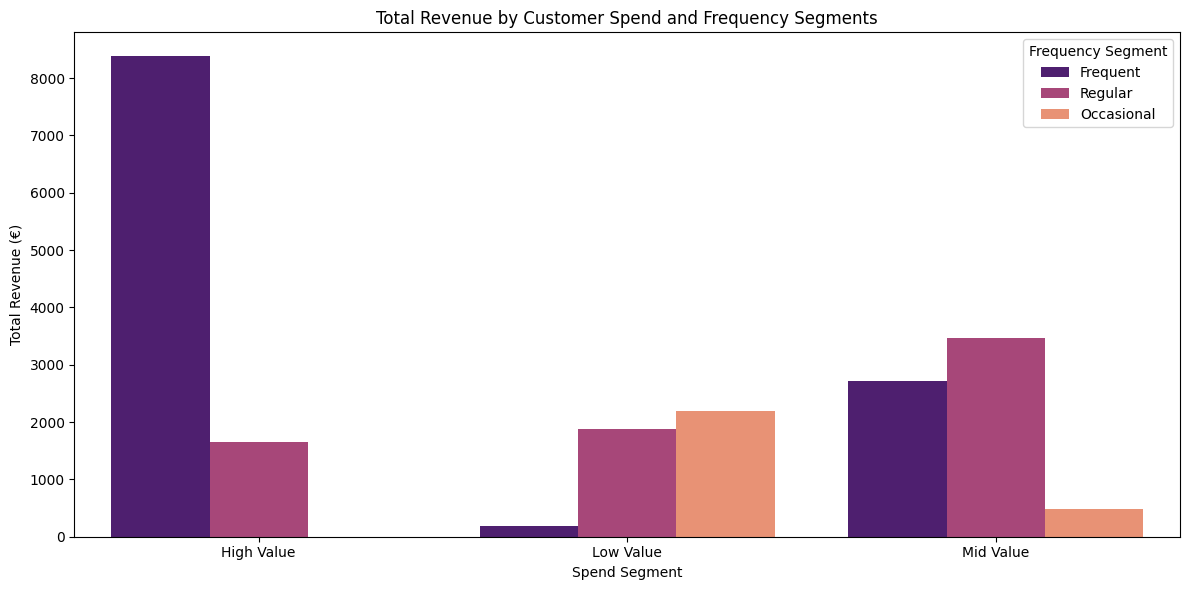

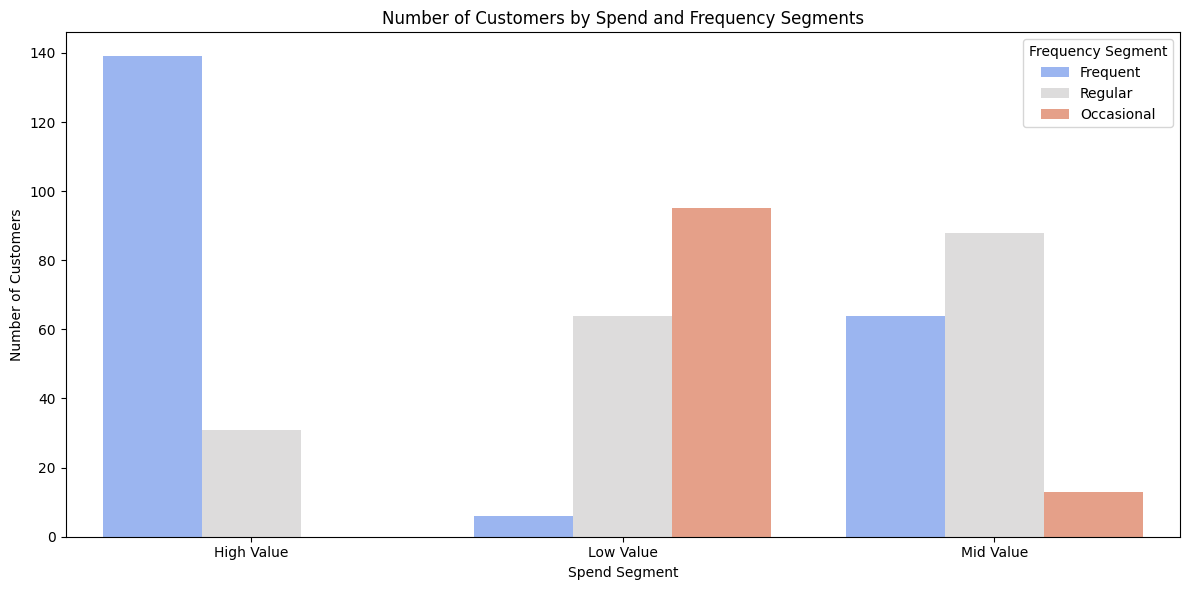

In [12]:
# === Visuals for Segmentation ===
plt.figure(figsize=(12, 6))
sns.barplot(data=segmentation_summary, x='SpendSegment', y='Total_Revenue', hue='FreqSegment', palette='magma')
plt.title('Total Revenue by Customer Spend and Frequency Segments')
plt.ylabel('Total Revenue (€)')
plt.xlabel('Spend Segment')
plt.legend(title='Frequency Segment')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=segmentation_summary, x='SpendSegment', y='Customers', hue='FreqSegment', palette='coolwarm')
plt.title('Number of Customers by Spend and Frequency Segments')
plt.ylabel('Number of Customers')
plt.xlabel('Spend Segment')
plt.legend(title='Frequency Segment')
plt.tight_layout()
plt.show()

In [13]:
# === Visuals ===

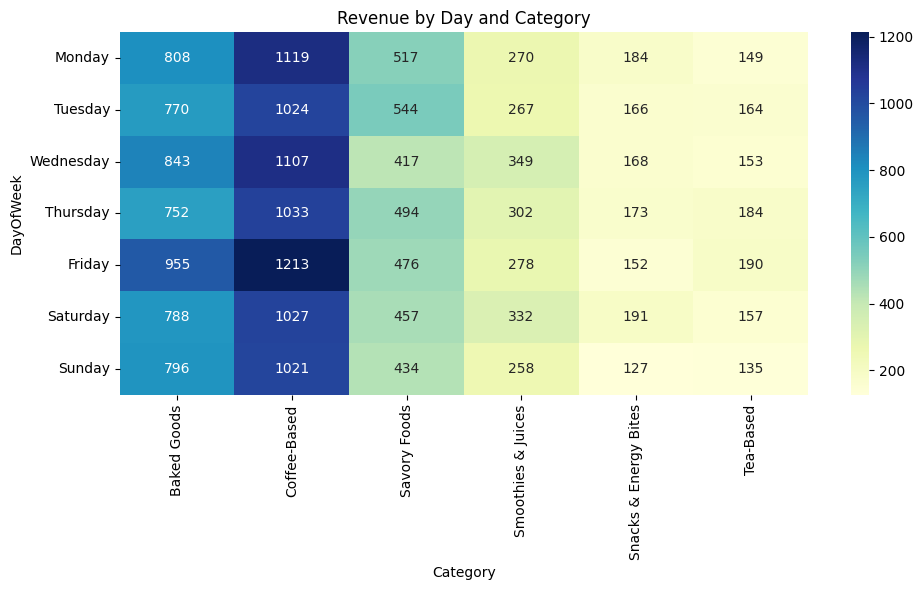

In [14]:
## Revenue by Day & Category
revenue_day_cat = df.groupby(['DayOfWeek', 'Category'])['Revenue'].sum().reset_index()
pivot = revenue_day_cat.pivot(index='DayOfWeek', columns='Category', values='Revenue')
pivot = pivot.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Revenue by Day and Category')
plt.tight_layout()
plt.show()

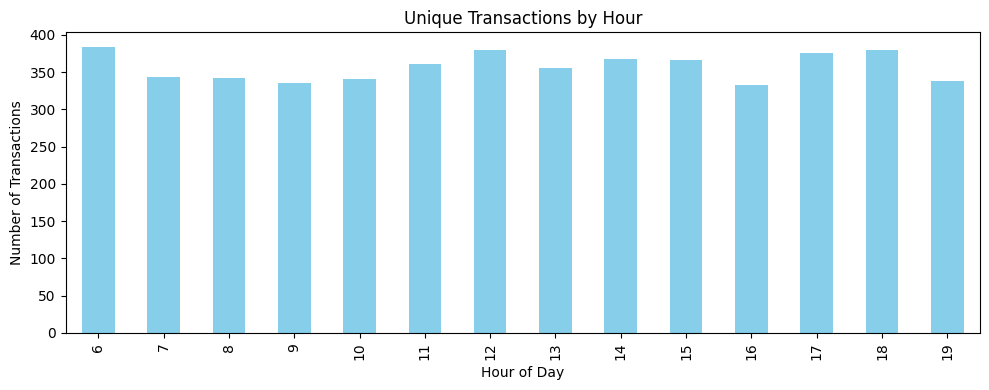

In [15]:
## Hourly Traffic
hourly_traffic = df.groupby('Hour')['TransactionID'].nunique()
hourly_traffic.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Unique Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

C:\Users\Martina\AppData\Local\Temp\ipykernel_22000\1204974220.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_perf_df.sort_values('Total_Revenue', ascending=False),


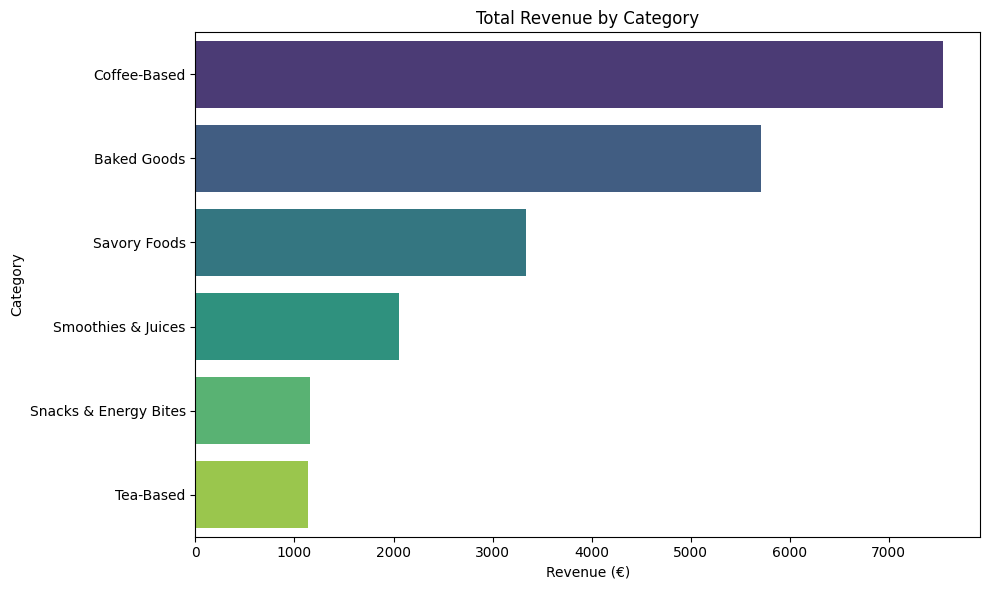

In [16]:
## Category Revenue Bar Plot
category_perf_df = df.groupby('Category').agg({
    'Revenue': ['sum', 'mean'],
    'TransactionID': 'nunique'
}).reset_index()
category_perf_df.columns = ['Category', 'Total_Revenue', 'Avg_Revenue_Per_Item', 'Unique_Transactions']

plt.figure(figsize=(10,6))
sns.barplot(data=category_perf_df.sort_values('Total_Revenue', ascending=False),
            x='Total_Revenue', y='Category', palette='viridis')
plt.title('Total Revenue by Category')
plt.xlabel('Revenue (€)')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

C:\Users\Martina\AppData\Local\Temp\ipykernel_22000\3438092018.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_avg_rev.sort_values('Avg_Revenue_Per_Transaction', ascending=False),


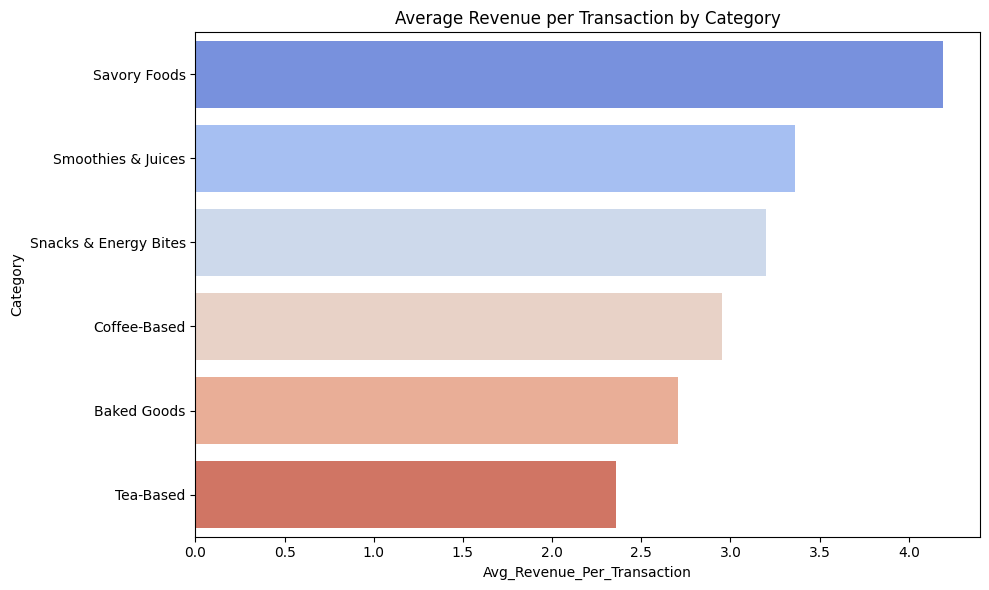

In [17]:
## Avg Revenue Per Transaction by Category
revenue_per_transaction = df.groupby(['Category', 'TransactionID'])['Revenue'].sum().reset_index()
category_avg_rev = revenue_per_transaction.groupby('Category')['Revenue'].mean().reset_index()
category_avg_rev.columns = ['Category', 'Avg_Revenue_Per_Transaction']

plt.figure(figsize=(10, 6))
sns.barplot(data=category_avg_rev.sort_values('Avg_Revenue_Per_Transaction', ascending=False),
            y='Category', x='Avg_Revenue_Per_Transaction', palette='coolwarm')
plt.title('Average Revenue per Transaction by Category')
plt.tight_layout()
plt.show()

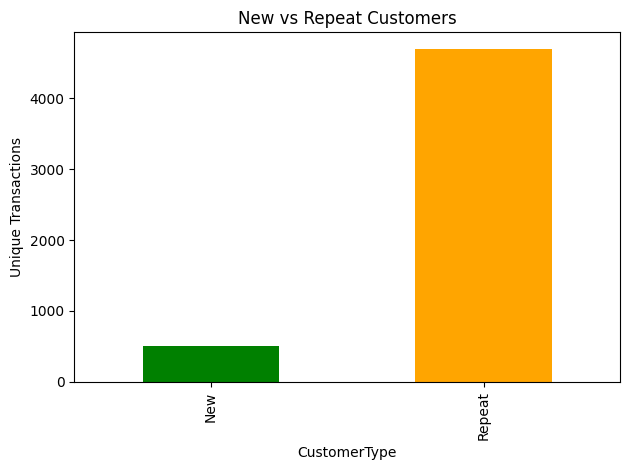

In [18]:
# === Loyalty Segmentation ===
df['CustomerType'] = df.duplicated(subset='CustomerID', keep='first').map({True: 'Repeat', False: 'New'})
segmented = df.groupby('CustomerType')['TransactionID'].nunique()
segmented.plot(kind='bar', color=['green', 'orange'])
plt.title('New vs Repeat Customers')
plt.ylabel('Unique Transactions')
plt.tight_layout()
plt.show()

In [27]:
# === Export for Power BI ===
df.to_csv('powerbi_transaction_level.csv', index=False)                       # full detail
customer_agg.to_csv('powerbi_customer_segments.csv', index=False)            # customer-level
segmentation_summary.to_csv('powerbi_segmentation_summary.csv', index=False)# matrix summary
category_perf.to_csv('powerbi_category_performance.csv', index=False)        # category-level
category_avg_rev.to_csv('powerbi_category_avg_transaction.csv', index=False)# category avg revenue